In [1]:
import csv
import os
from PIL import Image
import torch

base_dir = 'datasets/images/train'

dataset_list = [os.path.join(base_dir,file) for file in os.listdir(base_dir) if file.endswith('.png')]
dataset_list.sort()
label_list = [label.replace('.png', '.txt').replace('images','labels') for label in dataset_list]
# Combine dataset_list and label_list into a single dataset
combined_dataset = list(zip(dataset_list, label_list))
combined_dataset

[('datasets/images/train\\OBJ00022_PS3_K3_NIA0078.png',
  'datasets/labels/train\\OBJ00022_PS3_K3_NIA0078.txt'),
 ('datasets/images/train\\OBJ00028_PS3_K3_NIA0078.png',
  'datasets/labels/train\\OBJ00028_PS3_K3_NIA0078.txt'),
 ('datasets/images/train\\OBJ00032_PS3_K3_AIDATA0585.png',
  'datasets/labels/train\\OBJ00032_PS3_K3_AIDATA0585.txt'),
 ('datasets/images/train\\OBJ00036_PS3_K3_AIDATA0585.png',
  'datasets/labels/train\\OBJ00036_PS3_K3_AIDATA0585.txt'),
 ('datasets/images/train\\OBJ00059_PS3_K3_AIDATA0587.png',
  'datasets/labels/train\\OBJ00059_PS3_K3_AIDATA0587.txt'),
 ('datasets/images/train\\OBJ00068_PS3_K3_AIDATA0587.png',
  'datasets/labels/train\\OBJ00068_PS3_K3_AIDATA0587.txt'),
 ('datasets/images/train\\OBJ00111_PS3_K3A_AIDATA0589.png',
  'datasets/labels/train\\OBJ00111_PS3_K3A_AIDATA0589.txt'),
 ('datasets/images/train\\OBJ00115_PS3_K3A_AIDATA0591.png',
  'datasets/labels/train\\OBJ00115_PS3_K3A_AIDATA0591.txt'),
 ('datasets/images/train\\OBJ00116_PS3_K3A_AIDATA0591.pn

In [2]:
import cv2
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

def cluster_and_crop(image_path, k=2, size=1024, crop_num=43, threshold=0.7):
    # 이미지 로드 및 리사이즈
    img = Image.open(image_path)
    img = img.resize((size, size))
    
    # 이미지를 numpy 배열로 변환 (RGB 값 형태)
    img_np = np.array(img)
    
    # 이미지 데이터를 준비 (픽셀 수, 3) 형태로 변형
    img_data = img_np.reshape((-1, 3))
    img_data = np.float32(img_data)

    # K-Means 적용
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(img_data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # 클러스터링 결과를 이미지로 변환
    centers = np.uint8(centers)
    segmented_img = centers[labels.flatten()]
    segmented_img = segmented_img.reshape(img_np.shape)

    # 검은색에 가장 가까운 클러스터 찾기
    black_cluster_index = np.argmin(np.linalg.norm(centers, axis=1))  # 가장 작은 RGB 값이 검은색
    
    # crop 영역 추출
    num_patches = []
    crop_size = segmented_img.shape[1] // crop_num
    for i in range(crop_num):
        for j in range(crop_num):
            
            crop_img = segmented_img[i * crop_size:(i + 1) * crop_size, j * crop_size:(j + 1) * crop_size]

            # 검은색 클러스터 비율 확인
            cluster_0_value = centers[black_cluster_index]
            cluster_0_mask = np.all(crop_img == cluster_0_value, axis=-1)
            if np.mean(cluster_0_mask) > threshold:
                num_patches.append((i, j))

    
    return num_patches

def save_cropped_patches_as_numpy(image_path, 
                                  image_path_cluster,
                                  crop_size, 
                                  resize_size,
                                  cluster_img_size,
                                  cluster_threshold,
                                  save_dir):
    image_name = os.path.basename(image_path)
    print(f"Processing {image_name}")
    image = Image.open(image_path_cluster).convert('RGB')
    
    image_width, image_height = image.size
    
    # num_patches = cluster_and_crop(image_path, 
    #                                k=3, 
    #                                size=cluster_img_size, 
    #                                crop_num=(image_width + crop_size - 1) // crop_size, 
    #                                threshold=cluster_threshold)
    
    num_patches = [(i, j) for i in range((image_width + crop_size - 1) // crop_size) for j in range((image_height + crop_size - 1) // crop_size)]
    
    image = Image.open(image_path)
    for i, j in tqdm(num_patches):
        top_left_x = i * crop_size
        top_left_y = j * crop_size
        bottom_right_x = min(top_left_x + crop_size, image_width)
        bottom_right_y = min(top_left_y + crop_size, image_height)
        
        if bottom_right_x - top_left_x < crop_size:
            top_left_x = max(image_width - crop_size, 0)
            bottom_right_x = image_width
        if bottom_right_y - top_left_y < crop_size:
            top_left_y = max(image_height - crop_size, 0)
            bottom_right_y = image_height
        
        cropped_image = image.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
        
        cropped_image = cropped_image.resize((resize_size, resize_size), resample=Image.Resampling.LANCZOS)
        
        crop_filename = f"{os.path.splitext(image_name)[0]}_{top_left_x}_{top_left_y}.png"
        crop_path = os.path.join(save_dir, crop_filename)
        cropped_image.save(crop_path, format="PNG")


    del image

crop_size = 256
resize_size = 1024
cluster_img_size = 1024
cluster_threshold = 0.0
target_dir = './target_dir'
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

save_cropped_patches_as_numpy(
    "./image.png", "image.png",
                                          crop_size, 
                                          resize_size, 
                                          cluster_img_size,
                                          cluster_threshold,
                                          target_dir)

Processing image.png


100%|██████████| 602/602 [01:51<00:00,  5.40it/s]


In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

random.seed(44)

# 상대 좌표를 절대 좌표로 변환하는 함수
def convert_to_absolute(coords, img_size):
    h, w = img_size
    abs_coords = [(float(coords[i]) * w, float(coords[i+1]) * h) for i in range(0, len(coords), 2)]
    return abs_coords

def extract_polygons_and_images(image, label_list):
    """라벨 리스트에서 각 폴리곤의 이미지를 추출하는 함수"""
    img_size = image.shape[:2]  # (height, width)
    cropped_images = []
    masks = []
    class_labels = []
    
    for label in label_list:
        label_split = label.strip().split()
        if len(label_split) < 9:
            print(f"잘못된 라벨 형식: {label}")
            continue
        class_label = label_split[0]  # 클래스 라벨 추출
        coords = label_split[1:]  # 좌표 값만 추출
        
        # 절대 좌표로 변환
        obb_coords = convert_to_absolute(coords, img_size)
        polygon = np.array(obb_coords, dtype=np.int32)
    
        # 폴리곤 마스크 생성
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [polygon], 255)
        cropped_img = cv2.bitwise_and(image, image, mask=mask)
        
        masks.append(mask)
        cropped_images.append(cropped_img)
        class_labels.append(class_label)  # 클래스 라벨 저장
    
    return cropped_images, masks, class_labels

def rotate_polygon(image, mask, angle):
    """이미지와 마스크를 주어진 각도로 회전시키는 함수"""
    (h, w) = mask.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 회전 후 이미지 크기를 모두 포함하도록 조정
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # 회전 변환 행렬에 이동을 추가
    M[0, 2] += (nW / 2) - center[0]
    M[1, 2] += (nH / 2) - center[1]

    rotated_image = cv2.warpAffine(image, M, (nW, nH))
    rotated_mask = cv2.warpAffine(mask, M, (nW, nH), flags=cv2.INTER_NEAREST)

    return rotated_image, rotated_mask

# def get_sea_mask(image, k=2):
#     """K-평균 클러스터링을 사용하여 바다 영역의 마스크를 생성하는 함수"""
#     hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     img_data = hsv_image.reshape((-1, 3))
#     img_data = np.float32(img_data)

#     # K-평균 클러스터링 적용
#     criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
#     attempts = 10
#     flags = cv2.KMEANS_PP_CENTERS
#     _, labels, centers = cv2.kmeans(img_data, k, None, criteria, attempts, flags)

#     # 클러스터 중심에서 바다에 해당하는 클러스터 식별
#     centers = np.uint8(centers)
#     # hue_values = centers[:, 0]
#     # # 바다의 Hue 값 범위 설정 (예시: 파란색 계열)
#     # sea_hue_range = (90, 140)
#     # sea_cluster_indices = np.where((hue_values >= sea_hue_range[0]) & (hue_values <= sea_hue_range[1]))[0]
#     sea_cluster_indices = np.argmin(np.linalg.norm(centers, axis=1))
#     # 바다 마스크 생성
#     sea_mask = np.isin(labels.flatten(), sea_cluster_indices).reshape(image.shape[:2]).astype(np.uint8)

#     return sea_mask

def get_sea_mask(image):
    """그레이스케일 이미지를 사용하여 밝은 영역을 제외한 바다 마스크를 생성하는 함수"""
    # 이미지를 그레이스케일로 변환
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 밝은 영역을 제외하기 위한 임계값 설정
    # 임계값은 이미지의 밝기에 따라 조정이 필요할 수 있습니다.
    threshold_value = 150  # 밝은 영역 기준 임계값 (0~255 사이의 값)
    
    # 임계값을 사용하여 이진화
    _, sea_mask = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY_INV)
    
    # 마스크를 이진 형태로 변환 (0과 1로 구성)
    sea_mask = (sea_mask / 255).astype(np.uint8)
    
    return sea_mask

def select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask):
    max_attempts = 1000
    attempts = 0

    while attempts < max_attempts:
        idx = random.randint(0, len(sea_positions) - 1)
        y, x = sea_positions[idx]
        offset_x = max(0, x - new_w // 2)
        offset_y = max(0, y - new_h // 2)

        # 이미지 경계 내에 위치하는지 확인
        if offset_x + new_w > target_w or offset_y + new_h > target_h:
            attempts += 1
            continue

        # mask_region 추출
        mask_region = sea_mask[offset_y:offset_y + new_h, offset_x:offset_x + new_w]

        if mask_region.shape[0] != new_h or mask_region.shape[1] != new_w:
            attempts += 1
            continue

        if np.all(mask_region == 1):
            return offset_x, offset_y
        else:
            attempts += 1

    return None, None

def resize_and_paste_polygons(cropped_images, masks, class_labels, target_img, sea_mask, scale=0.77/5, rotate_angle_range=(-180, 180)):
    """폴리곤 이미지를 리사이즈하고 바다 영역 내에 배치하는 함수"""
    all_polygons_coords = []
    all_class_labels = []

    # 바다 마스크에서 위치 추출
    sea_positions = np.argwhere(sea_mask == 1)
    target_h, target_w = target_img.shape[:2]

    for cropped_img, mask, class_label in zip(cropped_images, masks, class_labels):
        x, y, w, h = cv2.boundingRect(mask)
        cropped_polygon = cropped_img[y:y+h, x:x+w]
        mask_polygon = mask[y:y+h, x:x+w]

        # 이미지 리사이즈
        new_w = int(w * scale)
        new_h = int(h * scale)

        if new_w <= 1 or new_h <= 1:
            print("리사이즈 후 이미지가 너무 작아 생략합니다.")
            continue

        resized_polygon = cv2.resize(cropped_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)
        resized_mask = cv2.resize(mask_polygon, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # 무작위 회전 적용
        random_angle = random.uniform(rotate_angle_range[0], rotate_angle_range[1])
        rotated_polygon, rotated_mask = rotate_polygon(resized_polygon, resized_mask, random_angle)

        # 회전 후 이미지 크기 업데이트
        new_h, new_w = rotated_mask.shape[:2]

        # 바다 마스크에서 위치 선택
        offset_x, offset_y = select_position_from_mask(sea_positions, target_w, target_h, new_w, new_h, sea_mask)

        if offset_x is None:
            print("적절한 위치를 찾지 못해 생략합니다.")
            continue

        # 회전된 마스크에서 컨투어 추출
        contours, _ = cv2.findContours(rotated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            print("회전된 마스크에서 폴리곤을 찾을 수 없습니다.")
            continue
        cnt = contours[0]

        # 회전된 사각형 구하기
        rot_rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rot_rect)
        box = box.astype(int)

        # 좌표를 타겟 이미지 좌표계로 변환
        box_in_target = box + np.array([offset_x, offset_y])

        all_polygons_coords.append(box_in_target)
        all_class_labels.append(class_label)  # 클래스 라벨 저장

        # 타겟 이미지에 폴리곤 붙여넣기
        region_of_interest = target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w]
        mask_inv = cv2.bitwise_not(rotated_mask)

        target_bg = cv2.bitwise_and(region_of_interest, region_of_interest, mask=mask_inv)
        polygon_fg = cv2.bitwise_and(rotated_polygon, rotated_polygon, mask=rotated_mask)

        combined = cv2.add(target_bg, polygon_fg)
        target_img[offset_y:offset_y+new_h, offset_x:offset_x+new_w] = combined

    return target_img, all_polygons_coords, all_class_labels

def save_image_and_label(image, label_coords, class_labels, image_num):
    """증강된 이미지와 라벨 파일을 저장하는 함수"""
    image_save_path = f"./dataset3/images/augments{image_num}.png"
    label_save_path = f"./dataset3/labels/augments{image_num}.txt"

    # 이미지 저장
    cv2.imwrite(image_save_path, image)

    # 이미지 크기
    img_h, img_w = image.shape[:2]

    # 라벨 저장
    with open(label_save_path, 'w') as label_file:
        for polygon, class_label in zip(label_coords, class_labels):
            # 좌표를 (x1, y1, x2, y2, x3, y3, x4, y4) 순서로 정렬
            polygon = polygon.astype(np.float32)
            relative_coords = polygon / [img_w, img_h]
            relative_coords = relative_coords.flatten()
            # 좌표 개수가 8개인지 확인
            if len(relative_coords) != 8:
                print(f"좌표 개수가 8개가 아닙니다: {relative_coords}")
                continue
            coords_str = ' '.join(map(str, relative_coords))
            label_file.write(f"{class_label} {coords_str}\n")

def augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=(512, 512), scale=0.77/2.5, rotate_angle_range=(-180, 180)):
    os.makedirs("./dataset3/images/", exist_ok=True)
    os.makedirs("./dataset3/labels/", exist_ok=True)

    for augment_num in range(1, num_augments + 1):
        while True:
            # 타겟 이미지 선택 및 초기화
            target_img_path = random.choice(target_dir_list)
            target_img = cv2.imread(target_img_path)
            if target_img is None:
                print(f"타겟 이미지 {target_img_path}를 찾을 수 없습니다.")
                continue

            target_img = cv2.resize(target_img, target_size)

            # 바다 마스크 생성
            sea_mask = get_sea_mask(target_img)

            # 바다 위치 추출
            sea_positions = np.argwhere(sea_mask == 1)
            if len(sea_positions) == 0:
                print(f"타겟 이미지 {target_img_path}에서 바다 영역을 찾을 수 없습니다. 다른 이미지를 선택합니다.")
                continue
            else:
                break

        all_polygons_coords = []
        all_class_labels = []
        
        # 샘플링한 데이터 처리
        sampled_data = random.sample(combined_dataset, num_samples)
        
        for source_img_path, source_label_path in sampled_data:
            # 소스 이미지와 라벨 로드
            try:
                with open(source_label_path, 'r') as f:
                    source_label_list = f.read().strip().split('\n')
            except FileNotFoundError:
                print(f"라벨 파일 {source_label_path}를 찾을 수 없습니다.")
                continue

            source_img = cv2.imread(source_img_path)
            if source_img is None:
                print(f"소스 이미지 {source_img_path}를 찾을 수 없습니다.")
                continue

            # 폴리곤 이미지 및 마스크 추출
            cropped_images, masks, class_labels = extract_polygons_and_images(source_img, source_label_list)

            # 폴리곤을 리사이즈하고 타겟 이미지에 붙여넣기
            target_img, polygon_coords, updated_class_labels = resize_and_paste_polygons(
                cropped_images, masks, class_labels, target_img, sea_mask, scale=scale, rotate_angle_range=rotate_angle_range)
            all_polygons_coords.extend(polygon_coords)
            all_class_labels.extend(updated_class_labels)

        # 증강된 이미지와 라벨 저장
        save_image_and_label(target_img, all_polygons_coords, all_class_labels, augment_num)

# 사용 예시
num_samples = 1  # 샘플링할 이미지 수
num_augments = 100  # 생성할 증강 이미지 수
target_size = (512, 512)  # 타겟 이미지 크기
scale = 0.77 / 5  # 리사이즈 스케일

# combined_dataset와 target_dir_list가 정의되어 있다고 가정합니다.
# combined_dataset = [(소스 이미지 경로, 라벨 경로), ...]
# target_dir_list = [타겟 이미지 경로1, 타겟 이미지 경로2, ...]
target_dir = './target_dir'
target_dir_list = [os.path.join(target_dir, file) for file in os.listdir(target_dir) if file.endswith('.png')]

# 증강 이미지 생성
augment_and_save_images(combined_dataset, target_dir_list, num_samples, num_augments, target_size=target_size, scale=scale)

리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.
리사이즈 후 이미지가 너무 작아 생략합니다.


시각화 중: augments1.png 및 augments1.txt


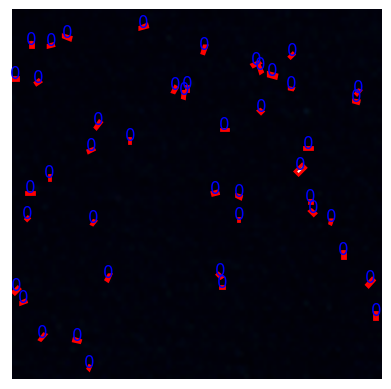

시각화 중: augments10.png 및 augments10.txt


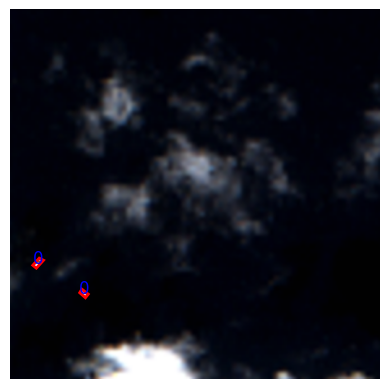

시각화 중: augments2.png 및 augments2.txt


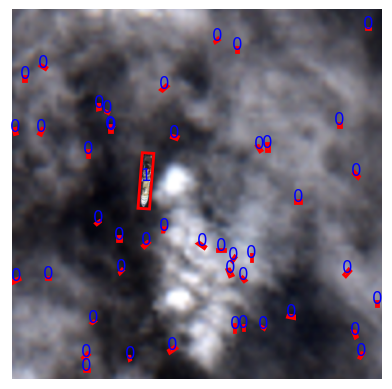

시각화 중: augments3.png 및 augments3.txt


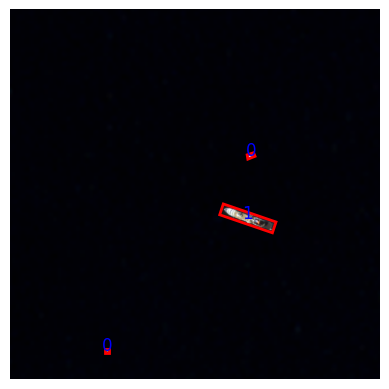

시각화 중: augments4.png 및 augments4.txt


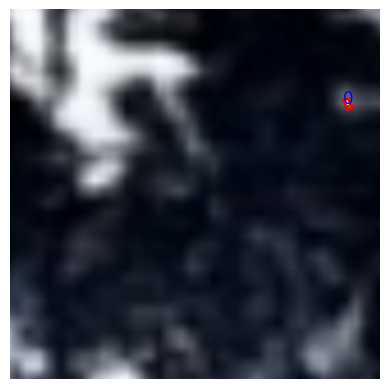

시각화 중: augments5.png 및 augments5.txt


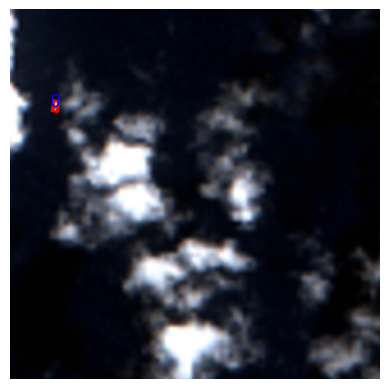

시각화 중: augments6.png 및 augments6.txt


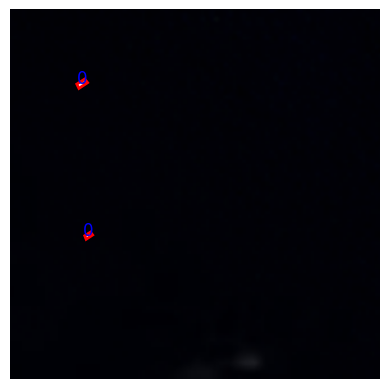

시각화 중: augments7.png 및 augments7.txt


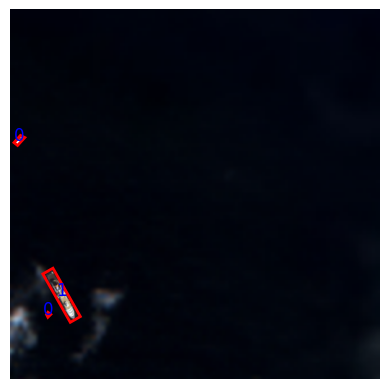

시각화 중: augments8.png 및 augments8.txt


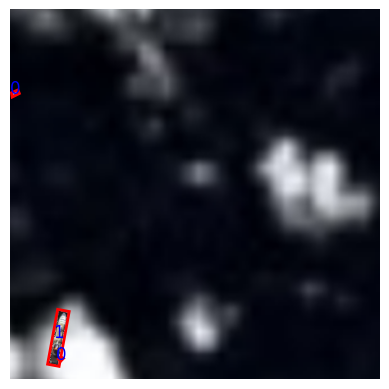

시각화 중: augments9.png 및 augments9.txt


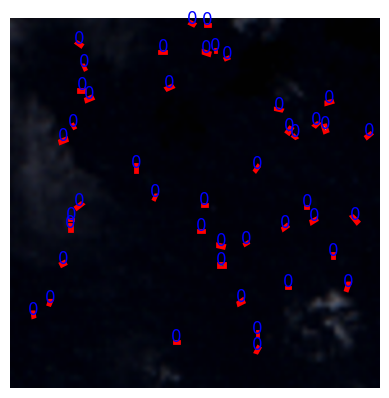

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def visualize_image_with_coords(image_path, coords_list):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for class_name, coords in coords_list:
        # coords: [x1, y1, x2, y2, x3, y3, x4, y4]
        coords = np.array(coords)
        coords = coords.reshape(4, 2)  # 4개의 좌표쌍 (x, y)으로 변환

        # 다각형 그리기 (4개의 좌표를 사용한 회전된 바운딩 박스)
        polygon = patches.Polygon(coords, closed=True, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(polygon)

        # 클래스 이름 표시 (옵션)
        cx, cy = np.mean(coords[:, 0]), np.mean(coords[:, 1])  # 중심 좌표
        ax.text(cx, cy, class_name, color='blue', fontsize=12, ha='center')

    plt.axis('off')
    plt.show()

def visualize_labels_on_image(image_path, label_path):
    img = Image.open(image_path)
    img_w, img_h = img.size

    coords_list = []
    with open(label_path, 'r') as f:
        label_lines = f.readlines()

    for label_line in label_lines:
        label_split = label_line.strip().split()
        if len(label_split) != 9:
            print(f"잘못된 라벨 형식: {label_line}")
            continue
        class_label = label_split[0]
        coords = list(map(float, label_split[1:]))

        # 상대 좌표를 절대 좌표로 변환
        abs_coords = []
        for i in range(0, len(coords), 2):
            x_rel = coords[i]
            y_rel = coords[i+1]
            x_abs = x_rel * img_w
            y_abs = y_rel * img_h
            abs_coords.extend([x_abs, y_abs])

        coords_list.append((class_label, abs_coords))

    # 변환된 좌표를 사용하여 시각화 함수 호출
    visualize_image_with_coords(image_path, coords_list)

# 사용 예시
image_dir = "./dataset3/images/"
label_dir = "./dataset3/labels/"

# 디렉토리 내의 파일들을 가져옵니다.
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])

# 이미지와 라벨을 하나씩 시각화합니다.
for image_file, label_file in zip(image_files, label_files):
    image_path = os.path.join(image_dir, image_file)
    label_path = os.path.join(label_dir, label_file)
    print(f"시각화 중: {image_file} 및 {label_file}")
    visualize_labels_on_image(image_path, label_path)